In [1]:
from tqdm import tqdm
import wandb
import pandas as pd 
api = wandb.Api()

# Project is specified by <entity/project-name>

def extract_run(tag):
    runs = api.runs("grabus/spectralRegularization")
    summary_list = [] 
    config_list = [] 
    name_list = [] 
    tags_list = []
    runs_histories = {}
    for run in tqdm(runs): 
        # run.summary are the output key/values like accuracy.
        # We call ._json_dict to omit large files 
        if not tag in run.tags:
            continue
        summary_list.append(run.summary._json_dict) 
        # run.config is the input metrics.
        # We remove special values that start with _.

        config = {k:v for k,v in run.config.items() if not k.startswith('_')}
        config['id'] = run.id
        config_list.append(config) 

        # run.name is the name of the run.
        name_list.append(run.name)    
        tags_list.append(run.tags)
        runs_histories[run.id] = run.history()

    summary_df = pd.DataFrame.from_records(summary_list) 
    config_df = pd.DataFrame.from_records(config_list) 
    name_df = pd.DataFrame({'name': name_list}) 
    tags_df = pd.DataFrame({'tags': tags_list}) 
    all_df = pd.concat([name_df, config_df,summary_df, tags_df], axis=1)
    return config_df,runs_histories

def plot_results(config_df, runs_histories, metric):
    def get_best_epoch_metrics(runs,get_best_epoch):
        return dict([(k,run.loc[get_best_epoch(run)]) for k,run in runs.items()])

    get_best_epoch = lambda df: df.idxmin()['val_loss']
    best_epoch_metrics = get_best_epoch_metrics(runs_histories,get_best_epoch)

    best_epoch_metrics_and_hyperparams = config_df.set_index('id')\
                .join(pd.DataFrame.from_dict(best_epoch_metrics,orient='index'),
                      lsuffix='_config')
    gb = best_epoch_metrics_and_hyperparams.groupby(['train_size','stop_proba','hankel_russ_roul_type','lambd'])
    idx = gb.idxmin()['val_loss']
    results = best_epoch_metrics_and_hyperparams.loc[idx]

    import pylab as plt
    gb = results.groupby(['stop_proba','hankel_russ_roul_type','lambd','train_size'])
    #assert(all(s == 1 for s in gb.size()))
    legend = []
    #plt.figure(figsize=(12, 10)) 
    for params,df in gb.min().groupby(level=[0,1,2]):
        if params[0] > 0.01:
            continue
        xs = list(df.index.get_level_values('train_size'))
        ys = list(df[metric])
    #     if params[1] == 'block_diag':
    #         c = (0,0,params[2]*4+0.5)
    #     else:
    #         c = (0,params[2]*4+0.5,0)
        if params[2] == 0:
            ls = '--'
        else:
            ls = '-'

    #     plt.plot(xs,ys,c=c,ls=ls)
        plt.plot(xs,ys,ls=ls)
        legend.append(params)
    plt.legend(legend)
    plt.show()


In [2]:


df_emb,runs_emb = extract_run('test emb=4*voc')
df_noemb,runs_noemb = extract_run('test no embedding layer')


100%|██████████| 603/603 [00:03<00:00, 188.63it/s]


In [7]:
list(runs_emb.values())[0]

,_step,_runtime,tau,_timestamp,test8aim,test10aim,val_acc,train_hankel_loss,train_acc,val_aim,...,test12acc,test8loss,test10loss,test12aim,test8acc,test12loss,test10acc,ratio_correct_samples,val_loss,lr
0,1,7,9.0,1647900329,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,8,9.0,1647900330,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,8,9.0,1647900330,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,8,9.0,1647900330,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,8,9.0,1647900330,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,705,147,9.0,1647900469,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
525,706,147,9.0,1647900469,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526,707,147,9.0,1647900469,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527,708,147,9.0,1647900469,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


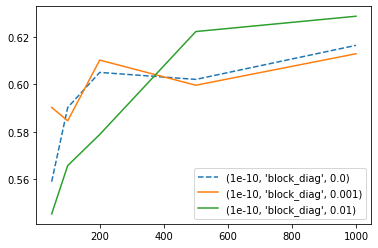

In [10]:
metric = 'test10acc'
plot_results(df_emb,runs_emb,metric)
#plot_results(df_noemb,runs_noemb,metric)

In [7]:
import torch

torch.save([all_df,runs_histories], 'xp_5_all_results.pt')
#all_df,runs_histories = torch.load('xp_5_all_results.pt')

In [3]:
pd.DataFrame.from_dict(best_epoch_metrics,orient='index').reset_index()
config_df.set_index('id').join(pd.DataFrame.from_dict(best_epoch_metrics,orient='index'))
s = pd.Series([1,0.1,2,0.5,3,4], index=[49, 48, 47, 0, 1, 2]) 
s.loc[s.idxmin()]

NameError: name 'best_epoch_metrics' is not defined

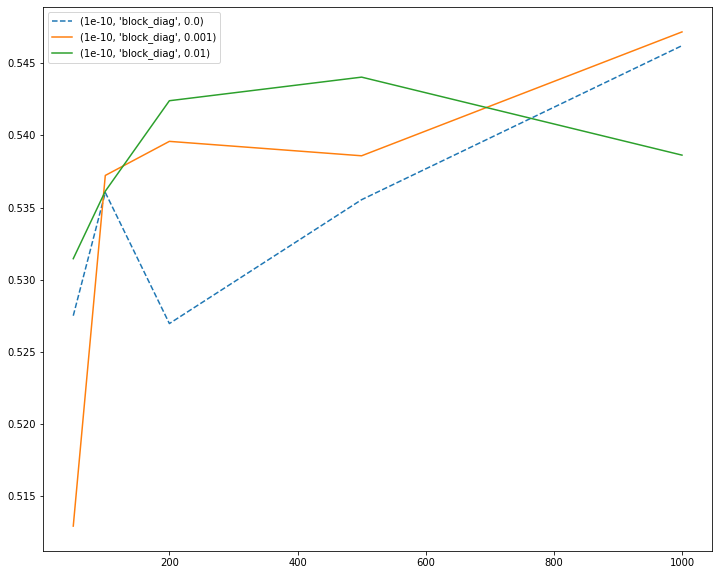

In [13]:
METRIC='test10aim'




In [27]:
idx = runs_histories['us2d68ce'].idxmin()['val_loss']
runs_histories['us2d68ce'].iloc[idx]

_step                6.300000e+01
_runtime             2.100000e+01
tau                           NaN
_timestamp           1.647792e+09
test_acc-14          4.564667e-01
val_acc              5.753019e-01
train_hankel_loss    1.621967e+00
train_acc            6.024432e-01
val_aim              5.538847e-01
train_cce_loss       7.821593e-01
test_aim-12          5.201154e-01
train_loss           9.443560e-01
train_aim            5.784659e-01
test_loss-12         9.645370e-01
test_acc-12          4.607308e-01
test_aim-10          5.300909e-01
test_loss-10         8.039070e-01
test_loss-14         9.661279e-01
test_acc-10          6.010000e-01
val_loss             7.971246e-01
test_aim-14          5.431333e-01
Name: 63, dtype: float64

In [18]:
runs_histories.idxmin()

AttributeError: 'dict' object has no attribute 'idxmin'